In [ ]:
import math, sys
from calflops import calculate_flops
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling
from datasets import load_dataset
import random

import torch.nn as nn
import copy

In [61]:
LiGO_bool = True
emb_size = 128
new_emb_size = 256
block_size = 64
multi_heads = 2
batch_size = 512
epochs = 3
learning_rate = 3e-4
device = torch.device('cuda:0')
num_small_layers = 4
multi_heads = 2
num_large_layers = 8
batches_per_epoch = 10
num_models = 2

In [62]:
# Dataset wikitext-2
dataset = load_dataset('wikitext', 'wikitext-2-v1')

# Dataset wikitext-103
# dataset = load_dataset('wikitext', 'wikitext-103-raw-v1')

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# padding token 
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size = len(tokenizer)

def tokenize_function(examples):
    return tokenizer(examples['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=block_size)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, collate_fn=data_collator)


In [63]:
from torch.utils.data import Subset

# Calculate the split points
train_split = len(train_dataset) // 2
val_split = len(val_dataset) // 2

# Create subsets for each half
train_dataset_1 = Subset(train_dataset, range(train_split))
train_dataset_2 = Subset(train_dataset, range(train_split, len(train_dataset)))

val_dataset_1 = Subset(val_dataset, range(val_split))
val_dataset_2 = Subset(val_dataset, range(val_split, len(val_dataset)))

# Create DataLoaders for each half
train_dataloader_1 = DataLoader(train_dataset_1, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_2 = DataLoader(train_dataset_2, shuffle=True, batch_size=batch_size, collate_fn=data_collator)

val_dataloader_1 = DataLoader(val_dataset_1, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_2 = DataLoader(val_dataset_2, shuffle=False, batch_size=batch_size, collate_fn=data_collator)

train_dataloader_1 = list(train_dataloader_1)
train_dataloader_2 = list(train_dataloader_2)

val_dataloader_1 = list(val_dataloader_1)
val_dataloader_2 = list(val_dataloader_2)

In [64]:
train_dataloader = list(train_dataloader)
val_dataloader = list(val_dataloader)

In [65]:
@torch.no_grad()
def validate(mdl, dataloader, device=device):
    loss_fn = torch.nn.CrossEntropyLoss()
    mdl.eval()
    total_loss = 0
    num_batches = 0
    ix = torch.randint(len(dataloader), tuple([5]))
    # dataloader = list(dataloader)
    for index in ix:
        batch = dataloader[index]
        inputs = batch["input_ids"].detach().clone().detach().squeeze(1).to(device)
        labels = batch["labels"].detach().clone().detach().to(device)
        outputs = mdl(inputs)
        loss = loss_fn(outputs.view(-1, vocab_size), labels.view(-1))
        total_loss += loss.item()
        num_batches += 1
        del loss
        del outputs
    return total_loss / num_batches

@torch.enable_grad()
def train(mdl, optim, epochs, train_dataloader=train_dataloader, val_dataloader=val_dataloader, device=device):
    loss_fn = torch.nn.CrossEntropyLoss()
    mdl.to(device)
    val_losses_epoch = []
    # train_dataloader = list(train_dataloader)
    for epoch in range(epochs):
        mdl.train()
        total_loss = 0
        num_batches = 0
        ix = torch.randint(len(train_dataloader), tuple([batches_per_epoch]))
        for index in ix:
            batch = train_dataloader[index]
            # print(f"Processing Batch: {index} in Epoch: {epoch}")
            inputs = batch["input_ids"].detach().clone().detach().to(device).squeeze(1)
            optim.zero_grad()
            outputs = mdl(inputs)
            labels = batch["labels"].detach().clone().detach().to(device)
            loss = loss_fn(outputs.view(-1, vocab_size), labels.view(-1))
            loss.backward()
            optim.step()
            total_loss += loss.item()
            num_batches += 1
            del loss
            del outputs
        avg_loss = total_loss / num_batches
        val_loss = validate(mdl, val_dataloader, device=device)
        val_losses_epoch.append(val_loss)
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return val_losses_epoch

In [66]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [67]:
class AttentionHead(torch.nn.Module):
    def __init__(self, big=False):
        super(AttentionHead, self).__init__()
        self.k = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.q = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.v = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    def forward(self, e):
        keys = self.k(e)
        queries = self.q(e)
        values = self.v(e)
        ret = keys @ queries.transpose(1, 2)*(1.0/math.sqrt(keys.size(-1)))
        ret = torch.masked_fill(ret, self.tril==0, -torch.inf)
        ret = torch.softmax(ret, 2)
        ret = ret @ values
        return ret

In [68]:
class MultiHead(torch.nn.Module):
    def __init__(self, big=False):
        super(MultiHead, self).__init__()
        self.head1 = AttentionHead(big)
        self.head2 = AttentionHead(big)
        self.mh_lin = torch.nn.Linear(multi_heads*(new_emb_size if big else emb_size), new_emb_size if big else emb_size, bias=False)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        x1 = self.head1(inp)
        x2 = self.head2(inp)
        return self.mh_lin(self.drop(torch.cat([x1,x2], dim=2))).relu()


In [69]:
class Block(torch.nn.Module):
    def __init__(self, big=False):
        super(Block, self).__init__()
        self.multihead = MultiHead(big)
        self.l_norm_1 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.l_norm_2 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.ffn = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        m = self.l_norm_1(inp + self.multihead(inp))
        m = self.l_norm_2(m + self.ffn(self.drop(m)).relu())
        return m

In [70]:
class Model(nn.Module):
    def __init__(self, layers_num):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pe = PositionalEncoding(d_model=emb_size)
        
        # Create a ModuleList to hold the blocks
        self.blocks = nn.ModuleList([Block() for _ in range(layers_num)])
        
        self.f_lin = nn.Linear(emb_size, vocab_size)
        self.drop = nn.Dropout(0.1)

    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        
        # Pass input through all blocks sequentially
        for block in self.blocks:
            e = block(e)
        
        r = self.f_lin(self.drop(e))
        return r

In [71]:
model1 = Model(4).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr = learning_rate)

model2 = Model(4).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = learning_rate)

In [72]:
train(model1, optimizer1, 30, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader_1)
train(model2, optimizer2, 30, train_dataloader=train_dataloader_2, val_dataloader=val_dataloader_2)

Epoch 1, Train Loss: 10.5971, Val Loss: 9.8715
Epoch 2, Train Loss: 9.7959, Val Loss: 9.1473
Epoch 3, Train Loss: 9.1520, Val Loss: 8.3703
Epoch 4, Train Loss: 8.5235, Val Loss: 7.7712
Epoch 5, Train Loss: 7.9393, Val Loss: 7.0743
Epoch 6, Train Loss: 7.4053, Val Loss: 6.6063
Epoch 7, Train Loss: 6.9145, Val Loss: 6.1506
Epoch 8, Train Loss: 6.4591, Val Loss: 5.7286
Epoch 9, Train Loss: 6.1084, Val Loss: 5.2531
Epoch 10, Train Loss: 5.7283, Val Loss: 4.9085
Epoch 11, Train Loss: 5.4267, Val Loss: 4.7048
Epoch 12, Train Loss: 5.1455, Val Loss: 4.3199
Epoch 13, Train Loss: 4.8981, Val Loss: 4.0747
Epoch 14, Train Loss: 4.6916, Val Loss: 3.9109
Epoch 15, Train Loss: 4.4852, Val Loss: 3.6799
Epoch 16, Train Loss: 4.3014, Val Loss: 3.5497
Epoch 17, Train Loss: 4.1153, Val Loss: 3.4317
Epoch 18, Train Loss: 3.9702, Val Loss: 3.2563
Epoch 19, Train Loss: 3.7739, Val Loss: 3.1678
Epoch 20, Train Loss: 3.6532, Val Loss: 2.9592
Epoch 21, Train Loss: 3.5112, Val Loss: 2.8590
Epoch 22, Train Loss:

[9.990516471862794,
 9.205245208740234,
 8.477274131774902,
 7.806951713562012,
 7.185374164581299,
 6.5776115417480465,
 6.044035148620606,
 5.646188163757325,
 5.263533020019532,
 4.864009761810303,
 4.567665672302246,
 4.29365758895874,
 4.082083034515381,
 3.9729843616485594,
 3.6576522827148437,
 3.5694539546966553,
 3.380833387374878,
 3.2991469860076905,
 3.1010719299316407,
 2.9866864681243896,
 2.897994565963745,
 2.72961802482605,
 2.663317012786865,
 2.544172430038452,
 2.4732322692871094,
 2.373012638092041,
 2.2753975868225096,
 2.18351354598999,
 2.102008819580078,
 2.0167514801025392]

In [73]:
class ModelComparator:
    def __init__(self):
        self.model1_state = None
        self.model2_state = None

    def save_model_states(self, model1, model2):
        self.model1_state = self._get_model_state(model1)
        self.model2_state = self._get_model_state(model2)
        print("Model states saved successfully.")

    def _get_model_state(self, model):
        return {name: param.clone().detach().cpu() for name, param in model.named_parameters()}

    def models_match(self, check_model1, check_model2):
        if self.model1_state is None or self.model2_state is None:
            raise ValueError("Model states have not been saved. Call save_model_states() first.")

        match1 = self._compare_model(check_model1, self.model1_state)
        match2 = self._compare_model(check_model2, self.model2_state)
        
        return match1 and match2

    def _compare_model(self, model, saved_state):
        current_state = self._get_model_state(model)
        
        if current_state.keys() != saved_state.keys():
            print(f"Model has different parameter structure than the saved state.")
            return False

        for name, param in current_state.items():
            if not torch.allclose(param, saved_state[name]):
                print(f"Mismatch in parameter: {name}")
                return False

        return True

In [74]:
comparator = ModelComparator()
comparator.save_model_states(model1, model2)


Model states saved successfully.


In [67]:
if comparator.models_match(model1, model2):
    print("Both models still match their original states")
else:
    print("At least one model has changed from its original state")

Both models still match their original states


In [69]:
scratch = Model(8)
optim_s = torch.optim.Adam(params=scratch.parameters(), lr=learning_rate)
scratch_curve = train(scratch, optim_s, 70, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 10.4963, Val Loss: 9.6975
Epoch 2, Train Loss: 9.6304, Val Loss: 8.7755
Epoch 3, Train Loss: 8.9549, Val Loss: 8.0772
Epoch 4, Train Loss: 8.3216, Val Loss: 7.3435
Epoch 5, Train Loss: 7.7643, Val Loss: 6.7570
Epoch 6, Train Loss: 7.2245, Val Loss: 6.2625
Epoch 7, Train Loss: 6.7792, Val Loss: 5.7913
Epoch 8, Train Loss: 6.3390, Val Loss: 5.4332
Epoch 9, Train Loss: 5.9169, Val Loss: 5.0178
Epoch 10, Train Loss: 5.6246, Val Loss: 4.6711
Epoch 11, Train Loss: 5.3175, Val Loss: 4.4280
Epoch 12, Train Loss: 5.0401, Val Loss: 4.1109
Epoch 13, Train Loss: 4.8161, Val Loss: 3.9098
Epoch 14, Train Loss: 4.6268, Val Loss: 3.7041
Epoch 15, Train Loss: 4.4287, Val Loss: 3.5764
Epoch 16, Train Loss: 4.2273, Val Loss: 3.4637
Epoch 17, Train Loss: 4.0779, Val Loss: 3.2754
Epoch 18, Train Loss: 3.9639, Val Loss: 3.1761
Epoch 19, Train Loss: 3.8049, Val Loss: 2.9698
Epoch 20, Train Loss: 3.7039, Val Loss: 2.9309
Epoch 21, Train Loss: 3.5601, Val Loss: 2.7570
Epoch 22, Train Loss:

### Double Stacking Models

In [70]:
class StackedModel(torch.nn.Module):
    def __init__(self, models, num_models, same=False):
        super(StackedModel, self).__init__()
        
        if len(models) != num_models:
            raise ValueError(f"Expected {num_models} models, but got {len(models)}")
        
        # Randomize the order of models
        random.shuffle(models)
        
        
        
        self.embedding = copy.deepcopy(models[0].embedding)
        self.pe = copy.deepcopy(models[0].pe)
        
        # Stack the blocks
        self.blocks = torch.nn.ModuleList()
        for model in models:
            self.blocks.extend(copy.deepcopy(model.blocks))
        
        if same:
            model_rand = random.choice(models)
            self.embedding = copy.deepcopy(model_rand.embedding)
            self.pe = copy.deepcopy(model_rand.pe)
            self.f_lin = copy.deepcopy(model_rand.f_lin)
        else:
            self.f_lin = copy.deepcopy(models[-1].f_lin)
        
        self.drop = torch.nn.Dropout(0.1)

    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        
        for block in self.blocks:
            e = block(e)
        
        r = self.f_lin(self.drop(e))
        return r

In [71]:
# class StackedModel3(torch.nn.Module):
#     def __init__(self, model1, model2, model3, same=False):
#         super(StackedModel3, self).__init__()
#         self.embedding = copy.deepcopy(model1.embedding)
#         self.pe = PositionalEncoding(d_model=128)

#         # Stack the blocks
#         self.block1 = copy.deepcopy(model1.block1)
#         self.block2 = copy.deepcopy(model1.block2)
#         self.block3 = copy.deepcopy(model1.block3)
#         self.block4 = copy.deepcopy(model1.block4)
        
#         self.block5 = copy.deepcopy(model2.block1)
#         self.block6 = copy.deepcopy(model2.block2)
#         self.block7 = copy.deepcopy(model2.block3)
#         self.block8 = copy.deepcopy(model2.block4)
        
#         self.block9 = copy.deepcopy(model3.block1)
#         self.block10 = copy.deepcopy(model3.block2)
#         self.block11 = copy.deepcopy(model3.block3)
#         self.block12 = copy.deepcopy(model3.block4)

#         if same:
#             self.final_linear = copy.deepcopy(model1.f_lin)
#         else: 
#             self.final_linear = copy.deepcopy(model3.f_lin)
#         self.drop = torch.nn.Dropout(0.1)

#     def forward(self, inp):
#         e = self.embedding(inp)
#         e = self.pe(e)
        
        
#         e = self.block1(e)
#         e = self.block2(e)
#         e = self.block3(e)
#         e = self.block4(e)
        
#         e = self.block5(e)
#         e = self.block6(e)
#         e = self.block7(e)
#         e = self.block8(e)
        
#         e = self.block9(e)
#         e = self.block10(e)
#         e = self.block11(e)
#         e = self.block12(e)

#         r = self.final_linear(self.drop(e))
#         return r

In [72]:
# class StackedModel4(torch.nn.Module):
#     def __init__(self, model1, model2, model3, model4, emb_size, vocab_size):
#         super(StackedModel4, self).__init__()
#         self.embedding = model1.embedding
#         self.pe = model1.pe

#         # Stack the blocks
#         self.block1 = copy.deepcopy(model1.block1)
#         self.block2 = copy.deepcopy(model1.block2)
#         self.block3 = copy.deepcopy(model1.block3)
#         self.block4 = copy.deepcopy(model1.block4)
#         self.block5 = copy.deepcopy(model2.block1)
#         self.block6 = copy.deepcopy(model2.block2)
#         self.block7 = copy.deepcopy(model2.block3)
#         self.block8 = copy.deepcopy(model2.block4)
#         self.block9 = copy.deepcopy(model3.block1)
#         self.block10 = copy.deepcopy(model3.block2)
#         self.block11 = copy.deepcopy(model3.block3)
#         self.block12 = copy.deepcopy(model3.block4)
#         self.block13 = copy.deepcopy(model4.block1)
#         self.block14 = copy.deepcopy(model4.block2)
#         self.block15 = copy.deepcopy(model4.block3)
#         self.block16 = copy.deepcopy(model4.block4)
        

       
#         self.final_linear = model4.f_lin
#         self.drop = torch.nn.Dropout(0.1)

#     def forward(self, inp):
#         e = self.embedding(inp)
#         e = self.pe(e)
        
        
#         e = self.block1(e)
#         e = self.block2(e)
#         e = self.block3(e)
#         e = self.block4(e)
#         e = self.block5(e)
#         e = self.block6(e)
#         e = self.block7(e)
#         e = self.block8(e)
#         e = self.block9(e)
#         e = self.block10(e)
#         e = self.block11(e)
#         e = self.block12(e)
#         e = self.block13(e)
#         e = self.block14(e)
#         e = self.block15(e)
#         e = self.block16(e)

#         r = self.final_linear(self.drop(e))
#         return r

In [73]:
class StackedModelAVG(torch.nn.Module):
    def __init__(self, models, num_models):
        super(StackedModelAVG, self).__init__()
        
        if len(models) != num_models:
            raise ValueError(f"Expected {num_models} models, but got {len(models)}")
        
        # Randomize the order of models
        random.shuffle(models)
        
        self.embedding = torch.nn.Embedding(vocab_size, emb_size)
        
        embedding_weights = [copy.deepcopy(model.embedding.weight) for model in models]
        avg_embedding_weight = sum(embedding_weights) / num_models

        self.embedding.weight = torch.nn.Parameter(avg_embedding_weight, requires_grad=True)

        self.pe = copy.deepcopy(models[0].pe)
        
        # Stack the blocks
        self.blocks = torch.nn.ModuleList()
        for model in models:
            self.blocks.extend(copy.deepcopy(model.blocks))
            
        self.f_lin = torch.nn.Linear(emb_size, vocab_size)

        linear_weights = [copy.deepcopy(model.f_lin.weight) for model in models]
        linear_biases = [copy.deepcopy(model.f_lin.bias) for model in models]

        avg_linear_weight = sum(linear_weights) / num_models
        avg_linear_bias = sum(linear_biases) / num_models

        self.f_lin.weight = torch.nn.Parameter(avg_linear_weight, requires_grad=True)
        self.f_lin.bias = torch.nn.Parameter(avg_linear_bias, requires_grad=True)
        
        self.drop = torch.nn.Dropout(0.1)

    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        
        for block in self.blocks:
            e = block(e)
        
        r = self.f_lin(self.drop(e))
        return r

In [76]:
def compare_parameters(large_model_params, small_model_params, layer_range, prefix, offset=0):
    for layer_idx in layer_range:
        large_layer_idx = layer_idx + offset
        small_layer_idx = layer_idx

        # List of parameter types in each block to compare
        param_types = [
            'multihead.head1.tril', 'multihead.head1.k.weight', 'multihead.head1.q.weight', 'multihead.head1.v.weight',
            'multihead.head2.tril', 'multihead.head2.k.weight', 'multihead.head2.q.weight', 'multihead.head2.v.weight',
            'multihead.mh_lin.weight',
            'l_norm_1.weight', 'l_norm_1.bias',
            'l_norm_2.weight', 'l_norm_2.bias',
            'ffn.weight', 'ffn.bias'
        ]

        for param_type in param_types:
            large_param_name = f'blocks.{large_layer_idx}.{param_type}'
            small_param_name = f'blocks.{small_layer_idx}.{param_type}'

            if large_param_name not in large_model_params:
                print(f"Key {large_param_name} not found in large_model_params.")
                continue
            if small_param_name not in small_model_params:
                print(f"Key {small_param_name} not found in small_model_params.")
                continue

            # Move parameters to the same device for comparison
            param_large = large_model_params[large_param_name].to(device)
            param_small = small_model_params[small_param_name].to(device)

            if not torch.equal(param_large, param_small):
                print(f"Parameter {param_type} does not match in {prefix} at layer {large_layer_idx}")

In [77]:
small_model_1_params = {k: v.to(device) for k, v in model1.state_dict().items()}

print("Small model 1 parameters:", small_model_1_params.keys())

stacked_model = StackedModel([model1, model2], num_models = 2)
optimizer_stacked = torch.optim.Adam(stacked_model.parameters(), lr=learning_rate)

# Extract parameters from the models and move to the same device
large_model_params = {k: v.to(device) for k, v in stacked_model.state_dict().items()}
small_model_1_params = {k: v.to(device) for k, v in model1.state_dict().items()}
small_model_2_params = {k: v.to(device) for k, v in model2.state_dict().items()}
print("Large model parameters:", large_model_params.keys())

# Compare the first 4 layers with model1
compare_parameters(large_model_params, small_model_1_params, range(4), 'model1')

# Compare the next 4 layers with model2
compare_parameters(large_model_params, small_model_2_params, range(4), 'model2', offset=4)


Small model 1 parameters: dict_keys(['embedding.weight', 'pe.pe', 'blocks.0.multihead.head1.tril', 'blocks.0.multihead.head1.k.weight', 'blocks.0.multihead.head1.q.weight', 'blocks.0.multihead.head1.v.weight', 'blocks.0.multihead.head2.tril', 'blocks.0.multihead.head2.k.weight', 'blocks.0.multihead.head2.q.weight', 'blocks.0.multihead.head2.v.weight', 'blocks.0.multihead.mh_lin.weight', 'blocks.0.l_norm_1.weight', 'blocks.0.l_norm_1.bias', 'blocks.0.l_norm_2.weight', 'blocks.0.l_norm_2.bias', 'blocks.0.ffn.weight', 'blocks.0.ffn.bias', 'blocks.1.multihead.head1.tril', 'blocks.1.multihead.head1.k.weight', 'blocks.1.multihead.head1.q.weight', 'blocks.1.multihead.head1.v.weight', 'blocks.1.multihead.head2.tril', 'blocks.1.multihead.head2.k.weight', 'blocks.1.multihead.head2.q.weight', 'blocks.1.multihead.head2.v.weight', 'blocks.1.multihead.mh_lin.weight', 'blocks.1.l_norm_1.weight', 'blocks.1.l_norm_1.bias', 'blocks.1.l_norm_2.weight', 'blocks.1.l_norm_2.bias', 'blocks.1.ffn.weight', 'bl

In [78]:
print("Large Model Parameters:")
print(large_model_params.keys())

print("\nSmall Model 1 Parameters:")
print(small_model_1_params.keys())

print("\nSmall Model 2 Parameters:")
print(small_model_2_params.keys())


Large Model Parameters:
dict_keys(['embedding.weight', 'pe.pe', 'blocks.0.multihead.head1.tril', 'blocks.0.multihead.head1.k.weight', 'blocks.0.multihead.head1.q.weight', 'blocks.0.multihead.head1.v.weight', 'blocks.0.multihead.head2.tril', 'blocks.0.multihead.head2.k.weight', 'blocks.0.multihead.head2.q.weight', 'blocks.0.multihead.head2.v.weight', 'blocks.0.multihead.mh_lin.weight', 'blocks.0.l_norm_1.weight', 'blocks.0.l_norm_1.bias', 'blocks.0.l_norm_2.weight', 'blocks.0.l_norm_2.bias', 'blocks.0.ffn.weight', 'blocks.0.ffn.bias', 'blocks.1.multihead.head1.tril', 'blocks.1.multihead.head1.k.weight', 'blocks.1.multihead.head1.q.weight', 'blocks.1.multihead.head1.v.weight', 'blocks.1.multihead.head2.tril', 'blocks.1.multihead.head2.k.weight', 'blocks.1.multihead.head2.q.weight', 'blocks.1.multihead.head2.v.weight', 'blocks.1.multihead.mh_lin.weight', 'blocks.1.l_norm_1.weight', 'blocks.1.l_norm_1.bias', 'blocks.1.l_norm_2.weight', 'blocks.1.l_norm_2.bias', 'blocks.1.ffn.weight', 'bloc

check if model params remain the same after training small models

In [81]:
if comparator.models_match(model1, model2):
    print("Both models still match their original states")
else:
    print("At least one model has changed from its original state")

Both models still match their original states


In [82]:
stack_curve = train(stacked_model, optimizer_stacked, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 7.1616, Val Loss: 5.3931
Epoch 2, Train Loss: 5.8056, Val Loss: 4.7493
Epoch 3, Train Loss: 5.2940, Val Loss: 4.3286
Epoch 4, Train Loss: 4.9952, Val Loss: 4.1929
Epoch 5, Train Loss: 4.8021, Val Loss: 3.8041
Epoch 6, Train Loss: 4.6233, Val Loss: 3.7974
Epoch 7, Train Loss: 4.4626, Val Loss: 3.6284
Epoch 8, Train Loss: 4.2628, Val Loss: 3.5452
Epoch 9, Train Loss: 4.1545, Val Loss: 3.3024
Epoch 10, Train Loss: 4.0253, Val Loss: 3.1907
Epoch 11, Train Loss: 3.9106, Val Loss: 3.0890
Epoch 12, Train Loss: 3.7912, Val Loss: 3.0182
Epoch 13, Train Loss: 3.6835, Val Loss: 2.9465
Epoch 14, Train Loss: 3.5633, Val Loss: 2.7625
Epoch 15, Train Loss: 3.4569, Val Loss: 2.6271
Epoch 16, Train Loss: 3.3485, Val Loss: 2.6010
Epoch 17, Train Loss: 3.2460, Val Loss: 2.4854
Epoch 18, Train Loss: 3.1833, Val Loss: 2.4007
Epoch 19, Train Loss: 3.0877, Val Loss: 2.3258
Epoch 20, Train Loss: 2.9899, Val Loss: 2.3108
Epoch 21, Train Loss: 2.9009, Val Loss: 2.1958
Epoch 22, Train Loss: 

<All keys matched successfully>

In [84]:
stacked_model_avg = StackedModelAVG([model1, model2], num_models = 2)
optimizer_stacked_avg = torch.optim.Adam(stacked_model_avg.parameters(), lr=learning_rate)


In [85]:
if comparator.models_match(model1, model2):
    print("Both models still match their original states")
else:
    print("At least one model has changed from its original state")

Both models still match their original states


In [86]:
stack_avg_curve = train(stacked_model_avg, optimizer_stacked_avg, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 5.2629, Val Loss: 3.8841
Epoch 2, Train Loss: 4.5306, Val Loss: 3.4248
Epoch 3, Train Loss: 4.1479, Val Loss: 3.2220
Epoch 4, Train Loss: 3.8691, Val Loss: 2.9943
Epoch 5, Train Loss: 3.6840, Val Loss: 2.8030
Epoch 6, Train Loss: 3.4987, Val Loss: 2.6475
Epoch 7, Train Loss: 3.3423, Val Loss: 2.5795
Epoch 8, Train Loss: 3.2203, Val Loss: 2.4466
Epoch 9, Train Loss: 3.0888, Val Loss: 2.3206
Epoch 10, Train Loss: 2.9617, Val Loss: 2.2651
Epoch 11, Train Loss: 2.8695, Val Loss: 2.1298
Epoch 12, Train Loss: 2.8020, Val Loss: 2.0734
Epoch 13, Train Loss: 2.6611, Val Loss: 1.9530
Epoch 14, Train Loss: 2.5773, Val Loss: 1.8953
Epoch 15, Train Loss: 2.5167, Val Loss: 1.8846
Epoch 16, Train Loss: 2.4150, Val Loss: 1.7614
Epoch 17, Train Loss: 2.3438, Val Loss: 1.6976
Epoch 18, Train Loss: 2.2536, Val Loss: 1.6527
Epoch 19, Train Loss: 2.1863, Val Loss: 1.5861
Epoch 20, Train Loss: 2.1183, Val Loss: 1.5477
Epoch 21, Train Loss: 2.0511, Val Loss: 1.4819
Epoch 22, Train Loss: 

<All keys matched successfully>

In [88]:
stacked_model_same = StackedModel([model1, model2], num_models = 2, same=True)
optimizer_stacked_same = torch.optim.Adam(stacked_model_same.parameters(), lr=learning_rate)

In [89]:
if comparator.models_match(model1, model2):
    print("Both models still match their original states")
else:
    print("At least one model has changed from its original state")

Both models still match their original states


In [90]:
stack_same_curve = train(stacked_model_same, optimizer_stacked_same, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 3.7087, Val Loss: 2.5053
Epoch 2, Train Loss: 3.1418, Val Loss: 2.2677
Epoch 3, Train Loss: 2.8825, Val Loss: 2.0843
Epoch 4, Train Loss: 2.7075, Val Loss: 2.0223
Epoch 5, Train Loss: 2.5966, Val Loss: 1.8837
Epoch 6, Train Loss: 2.4911, Val Loss: 1.8218
Epoch 7, Train Loss: 2.3864, Val Loss: 1.7470
Epoch 8, Train Loss: 2.3155, Val Loss: 1.6743
Epoch 9, Train Loss: 2.2066, Val Loss: 1.6205
Epoch 10, Train Loss: 2.1435, Val Loss: 1.5583
Epoch 11, Train Loss: 2.0763, Val Loss: 1.5329
Epoch 12, Train Loss: 1.9815, Val Loss: 1.4235
Epoch 13, Train Loss: 1.9499, Val Loss: 1.3751
Epoch 14, Train Loss: 1.8835, Val Loss: 1.3772
Epoch 15, Train Loss: 1.8131, Val Loss: 1.2915
Epoch 16, Train Loss: 1.7608, Val Loss: 1.2813
Epoch 17, Train Loss: 1.6999, Val Loss: 1.2343
Epoch 18, Train Loss: 1.6637, Val Loss: 1.1833
Epoch 19, Train Loss: 1.6104, Val Loss: 1.1186
Epoch 20, Train Loss: 1.5598, Val Loss: 1.1322
Epoch 21, Train Loss: 1.5346, Val Loss: 1.0706
Epoch 22, Train Loss: 

<All keys matched successfully>

### Cross Stack Models

In [92]:
class InterWeavedModel(torch.nn.Module):
    def __init__(self, models, num_models, same=False):
        super(InterWeavedModel, self).__init__()
        
        if len(models) != num_models:
            raise ValueError(f"Expected {num_models} models, but got {len(models)}")
        
        # Randomize the order of models
        random.shuffle(models)
        
        self.embedding = copy.deepcopy(models[0].embedding)
        self.pe = copy.deepcopy(models[0].pe)
        
        # Interweave the blocks from all models
        self.blocks = torch.nn.ModuleList()
        num_blocks_per_model = len(models[0].blocks)
        
        for i in range(num_blocks_per_model):
            for model in models:
                self.blocks.append(copy.deepcopy(model.blocks[i]))
        
        if same:
            model_rand = random.choice(models)
            self.embedding = copy.deepcopy(model_rand.embedding)
            self.pe = copy.deepcopy(model_rand.pe)
            self.f_lin = copy.deepcopy(model_rand.f_lin)
        else:
            self.f_lin = copy.deepcopy(models[-1].f_lin)
        
        self.drop = torch.nn.Dropout(0.1)

    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        
        # Pass through all interweaved blocks
        for block in self.blocks:
            e = block(e)
        
        r = self.f_lin(self.drop(e))
        return r

In [95]:
class InterWeavedModelAVG(torch.nn.Module):
    def __init__(self, models, num_models, same=False):
        super(InterWeavedModelAVG, self).__init__()
        
        if len(models) != num_models:
            raise ValueError(f"Expected {num_models} models, but got {len(models)}")
        
        # Randomize the order of models
        random.shuffle(models)
        
        
        self.embedding = torch.nn.Embedding(vocab_size, emb_size)
        
        embedding_weights = [copy.deepcopy(model.embedding.weight) for model in models]
        avg_embedding_weight = sum(embedding_weights) / num_models

        self.embedding.weight = torch.nn.Parameter(avg_embedding_weight, requires_grad=True)

        self.pe = copy.deepcopy(models[0].pe)
        
        # Interweave the blocks from all models
        self.blocks = torch.nn.ModuleList()
        num_blocks_per_model = len(models[0].blocks)
        
        for i in range(num_blocks_per_model):
            for model in models:
                self.blocks.append(copy.deepcopy(model.blocks[i]))
                
        self.f_lin = torch.nn.Linear(emb_size, vocab_size)

        linear_weights = [copy.deepcopy(model.f_lin.weight) for model in models]
        linear_biases = [copy.deepcopy(model.f_lin.bias) for model in models]

        avg_linear_weight = sum(linear_weights) / num_models
        avg_linear_bias = sum(linear_biases) / num_models

        self.f_lin.weight = torch.nn.Parameter(avg_linear_weight, requires_grad=True)
        self.f_lin.bias = torch.nn.Parameter(avg_linear_bias, requires_grad=True)
        
        self.drop = torch.nn.Dropout(0.1)

    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        
        # Pass through all interweaved blocks
        for block in self.blocks:
            e = block(e)
        
        r = self.f_lin(self.drop(e))
        return r

In [98]:
interweaved_model = InterWeavedModel([model1, model2], num_models = 2)
optimizer_interweaved = torch.optim.Adam(interweaved_model.parameters(), lr=learning_rate)

In [99]:
if comparator.models_match(model1, model2):
    print("Both models still match their original states")
else:
    print("At least one model has changed from its original state")

Both models still match their original states


In [100]:
interweaved_curve = train(interweaved_model, optimizer_interweaved, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 7.2712, Val Loss: 5.4762
Epoch 2, Train Loss: 5.9126, Val Loss: 4.7575
Epoch 3, Train Loss: 5.3969, Val Loss: 4.3743
Epoch 4, Train Loss: 5.0463, Val Loss: 4.1664
Epoch 5, Train Loss: 4.8512, Val Loss: 3.9599
Epoch 6, Train Loss: 4.6568, Val Loss: 3.7864
Epoch 7, Train Loss: 4.4532, Val Loss: 3.5364
Epoch 8, Train Loss: 4.2655, Val Loss: 3.4932
Epoch 9, Train Loss: 4.1588, Val Loss: 3.3351
Epoch 10, Train Loss: 4.0073, Val Loss: 3.1542
Epoch 11, Train Loss: 3.9168, Val Loss: 3.1073
Epoch 12, Train Loss: 3.7942, Val Loss: 2.9611
Epoch 13, Train Loss: 3.6878, Val Loss: 2.9201
Epoch 14, Train Loss: 3.5656, Val Loss: 2.7929
Epoch 15, Train Loss: 3.4725, Val Loss: 2.6527
Epoch 16, Train Loss: 3.3685, Val Loss: 2.6378
Epoch 17, Train Loss: 3.2435, Val Loss: 2.4664
Epoch 18, Train Loss: 3.1657, Val Loss: 2.4109
Epoch 19, Train Loss: 3.0753, Val Loss: 2.3797
Epoch 20, Train Loss: 2.9793, Val Loss: 2.2493
Epoch 21, Train Loss: 2.8742, Val Loss: 2.1853
Epoch 22, Train Loss: 

<All keys matched successfully>

In [102]:
interweaving_model_avg = InterWeavedModelAVG([model1, model2], num_models = 2)
optimizer_interweaving_avg = torch.optim.Adam(interweaving_model_avg.parameters(), lr=learning_rate)

In [103]:
if comparator.models_match(model1, model2):
    print("Both models still match their original states")
else:
    print("At least one model has changed from its original state")

Both models still match their original states


In [104]:
interweaved_avg_curve = train(interweaving_model_avg, optimizer_interweaving_avg, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 5.0945, Val Loss: 3.7490
Epoch 2, Train Loss: 4.4329, Val Loss: 3.3550
Epoch 3, Train Loss: 4.0715, Val Loss: 3.1424
Epoch 4, Train Loss: 3.8389, Val Loss: 2.9098
Epoch 5, Train Loss: 3.6081, Val Loss: 2.7734
Epoch 6, Train Loss: 3.4580, Val Loss: 2.6471
Epoch 7, Train Loss: 3.3045, Val Loss: 2.5051
Epoch 8, Train Loss: 3.1819, Val Loss: 2.3864
Epoch 9, Train Loss: 3.0700, Val Loss: 2.3011
Epoch 10, Train Loss: 2.9341, Val Loss: 2.1385
Epoch 11, Train Loss: 2.8340, Val Loss: 2.1100
Epoch 12, Train Loss: 2.7572, Val Loss: 2.0571
Epoch 13, Train Loss: 2.6443, Val Loss: 1.9606
Epoch 14, Train Loss: 2.5564, Val Loss: 1.8679
Epoch 15, Train Loss: 2.4753, Val Loss: 1.8092
Epoch 16, Train Loss: 2.3767, Val Loss: 1.7046
Epoch 17, Train Loss: 2.3227, Val Loss: 1.6403
Epoch 18, Train Loss: 2.2153, Val Loss: 1.5718
Epoch 19, Train Loss: 2.1850, Val Loss: 1.5394
Epoch 20, Train Loss: 2.0848, Val Loss: 1.4986
Epoch 21, Train Loss: 2.0226, Val Loss: 1.4457
Epoch 22, Train Loss: 

<All keys matched successfully>

In [106]:
interweaving_model_same = InterWeavedModel([model1, model2], num_models = 2, same=True)
optimizer_interweaving_same = torch.optim.Adam(interweaving_model_same.parameters(), lr=learning_rate)

In [107]:
if comparator.models_match(model1, model2):
    print("Both models still match their original states")
else:
    print("At least one model has changed from its original state")

Both models still match their original states


In [108]:
interweaved_same_curve = train(interweaving_model_same, optimizer_interweaving_same, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 3.4692, Val Loss: 2.4170
Epoch 2, Train Loss: 3.0388, Val Loss: 2.2140
Epoch 3, Train Loss: 2.8296, Val Loss: 2.0971
Epoch 4, Train Loss: 2.6762, Val Loss: 1.9398
Epoch 5, Train Loss: 2.5731, Val Loss: 1.8172
Epoch 6, Train Loss: 2.4348, Val Loss: 1.7893
Epoch 7, Train Loss: 2.3581, Val Loss: 1.6802
Epoch 8, Train Loss: 2.2539, Val Loss: 1.6605
Epoch 9, Train Loss: 2.1948, Val Loss: 1.6509
Epoch 10, Train Loss: 2.1341, Val Loss: 1.5485
Epoch 11, Train Loss: 2.0318, Val Loss: 1.4361
Epoch 12, Train Loss: 1.9712, Val Loss: 1.4235
Epoch 13, Train Loss: 1.9247, Val Loss: 1.3490
Epoch 14, Train Loss: 1.8487, Val Loss: 1.3288
Epoch 15, Train Loss: 1.7722, Val Loss: 1.2867
Epoch 16, Train Loss: 1.7385, Val Loss: 1.2725
Epoch 17, Train Loss: 1.6652, Val Loss: 1.2008
Epoch 18, Train Loss: 1.6382, Val Loss: 1.1904
Epoch 19, Train Loss: 1.5521, Val Loss: 1.1283
Epoch 20, Train Loss: 1.5106, Val Loss: 1.0895
Epoch 21, Train Loss: 1.4927, Val Loss: 1.1063
Epoch 22, Train Loss: 

<All keys matched successfully>

### Test Single Stacking

In [110]:
Single_Stacked_Model = StackedModel([model1, model1], num_models = 2)
optimizer_single_stacked = torch.optim.Adam(Single_Stacked_Model.parameters(), lr=learning_rate)

In [111]:
if comparator.models_match(model1, model2):
    print("Both models still match their original states")
else:
    print("At least one model has changed from its original state")

Both models still match their original states


In [112]:
single_stacked_curve = train(Single_Stacked_Model, optimizer_single_stacked, 70, train_dataloader, val_dataloader)
torch.save(Single_Stacked_Model.state_dict(), 'models/Single_Stacked_Model.pth')

Epoch 1, Train Loss: 3.0280, Val Loss: 2.1997
Epoch 2, Train Loss: 2.7442, Val Loss: 2.0250
Epoch 3, Train Loss: 2.6021, Val Loss: 1.9257
Epoch 4, Train Loss: 2.5093, Val Loss: 1.8857
Epoch 5, Train Loss: 2.3953, Val Loss: 1.8035
Epoch 6, Train Loss: 2.3309, Val Loss: 1.7277
Epoch 7, Train Loss: 2.2451, Val Loss: 1.6487
Epoch 8, Train Loss: 2.1786, Val Loss: 1.6139
Epoch 9, Train Loss: 2.0940, Val Loss: 1.5283
Epoch 10, Train Loss: 2.0314, Val Loss: 1.4830
Epoch 11, Train Loss: 1.9619, Val Loss: 1.4196
Epoch 12, Train Loss: 1.8984, Val Loss: 1.4524
Epoch 13, Train Loss: 1.8257, Val Loss: 1.3424
Epoch 14, Train Loss: 1.7861, Val Loss: 1.3666
Epoch 15, Train Loss: 1.7319, Val Loss: 1.2573
Epoch 16, Train Loss: 1.6779, Val Loss: 1.1990
Epoch 17, Train Loss: 1.6325, Val Loss: 1.1588
Epoch 18, Train Loss: 1.5819, Val Loss: 1.1454
Epoch 19, Train Loss: 1.5542, Val Loss: 1.1391
Epoch 20, Train Loss: 1.4772, Val Loss: 1.0983
Epoch 21, Train Loss: 1.4563, Val Loss: 1.0133
Epoch 22, Train Loss: 

In [113]:
Single_InterWeaved_Model = InterWeavedModel([model1, model1], num_models = 2)
optimizer_single_interweaved = torch.optim.Adam(Single_InterWeaved_Model.parameters(), lr=learning_rate)

In [114]:
if comparator.models_match(model1, model2):
    print("Both models still match their original states")
else:
    print("At least one model has changed from its original state")

Both models still match their original states


In [115]:
single_interweaved_curve = train(Single_InterWeaved_Model, optimizer_single_interweaved, 70, train_dataloader, val_dataloader)
torch.save(Single_InterWeaved_Model.state_dict(), 'models/Single_InterWeaved_Model.pth')

Epoch 1, Train Loss: 3.0863, Val Loss: 2.2281
Epoch 2, Train Loss: 2.7963, Val Loss: 2.0849
Epoch 3, Train Loss: 2.6595, Val Loss: 1.9941
Epoch 4, Train Loss: 2.5416, Val Loss: 1.9157
Epoch 5, Train Loss: 2.4308, Val Loss: 1.7856
Epoch 6, Train Loss: 2.3360, Val Loss: 1.7823
Epoch 7, Train Loss: 2.2686, Val Loss: 1.6642
Epoch 8, Train Loss: 2.1849, Val Loss: 1.6373
Epoch 9, Train Loss: 2.1150, Val Loss: 1.5372
Epoch 10, Train Loss: 2.0421, Val Loss: 1.4596
Epoch 11, Train Loss: 1.9943, Val Loss: 1.4406
Epoch 12, Train Loss: 1.9134, Val Loss: 1.4272
Epoch 13, Train Loss: 1.8422, Val Loss: 1.3491
Epoch 14, Train Loss: 1.7856, Val Loss: 1.3239
Epoch 15, Train Loss: 1.7182, Val Loss: 1.2695
Epoch 16, Train Loss: 1.6916, Val Loss: 1.2118
Epoch 17, Train Loss: 1.6426, Val Loss: 1.1472
Epoch 18, Train Loss: 1.6056, Val Loss: 1.1558
Epoch 19, Train Loss: 1.5409, Val Loss: 1.1271
Epoch 20, Train Loss: 1.5141, Val Loss: 1.0885
Epoch 21, Train Loss: 1.4446, Val Loss: 1.0679
Epoch 22, Train Loss: 

In [117]:
import pandas as pd, matplotlib as plt

In [116]:
#df = pd.DataFrame({'CrossLiGOv2 depth+width':clv2_depth_width_curve,'StackLiGOv2 depth+width':slv2_depth_width_curve,'CrossLiGO Depth+Width':cl_depth_width_curve, 'CrossLiGO depth':cl_depth_curve,'Big Model Depth+Width': scratch_depth_width, 'Big Model Depth': scratch_depth,'StackLiGO depth+width': sl_depth_width_curve, 'StackLiGO depth only': sl_depth_curve,'LiGO width only': ligo_width_curve, 'LiGO depth only': ligo_depth_curve, 'LiGO depth + width': ligo_depth_width_curve})

# Create a DataFrame with the data
df = pd.DataFrame({'Scratch': scratch_curve, 'Stacked Model': stack_curve, 'Stacked Model AVG': stack_avg_curve, 'Stacked Model Same': stack_same_curve, 'Interweaved Model': interweaved_curve, 'Interweaved Model AVG': interweaved_avg_curve, 'Interweaved Model Same': interweaved_same_curve, 'Single Stacked Model': single_stacked_curve, 'Single Interweaved Model': single_interweaved_curve})

<Axes: >

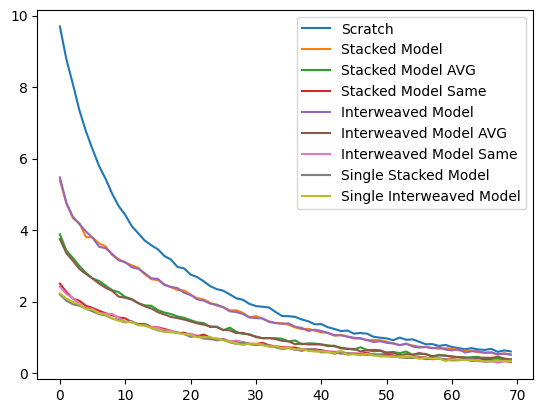

In [119]:
df.plot()

In [118]:
df.to_pickle('Wiki2_multi_model_curves')

### 3 Models

In [120]:
# Calculate the split points
train_split_3 = len(train_dataset) // 3
train_split_2_3 = 2 * len(train_dataset) // 3
val_split_3 = len(val_dataset) // 3
val_split_2_3 = 2 * len(val_dataset) // 3

# Create subsets for each third
train_dataset_1_3 = Subset(train_dataset, range(train_split_3))
train_dataset_2_3 = Subset(train_dataset, range(train_split_3, train_split_2_3))
train_dataset_3_3 = Subset(train_dataset, range(train_split_2_3, len(train_dataset)))

val_dataset_1_3 = Subset(val_dataset, range(val_split_3))
val_dataset_2_3 = Subset(val_dataset, range(val_split_3, val_split_2_3))
val_dataset_3_3 = Subset(val_dataset, range(val_split_2_3, len(val_dataset)))

# Create DataLoaders for each third
train_dataloader_1_3 = DataLoader(train_dataset_1_3, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_2_3 = DataLoader(train_dataset_2_3, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_3_3 = DataLoader(train_dataset_3_3, shuffle=True, batch_size=batch_size, collate_fn=data_collator)

val_dataloader_1_3 = DataLoader(val_dataset_1_3, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_2_3 = DataLoader(val_dataset_2_3, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_3_3 = DataLoader(val_dataset_3_3, shuffle=False, batch_size=batch_size, collate_fn=data_collator)

# Convert to lists if necessary
train_dataloader_1_3 = list(train_dataloader_1_3)
train_dataloader_2_3 = list(train_dataloader_2_3)
train_dataloader_3_3 = list(train_dataloader_3_3)

val_dataloader_1_3 = list(val_dataloader_1_3)
val_dataloader_2_3 = list(val_dataloader_2_3)
val_dataloader_3_3 = list(val_dataloader_3_3)

In [121]:
# Train the models on each third
model3_1 = Model(4).to(device)
optimizer3_1 = torch.optim.Adam(model3_1.parameters(), lr=learning_rate)

model3_2 = Model(4).to(device)
optimizer3_2 = torch.optim.Adam(model3_2.parameters(), lr=learning_rate)

model3_3 = Model(4).to(device)
optimizer3_3 = torch.optim.Adam(model3_3.parameters(), lr=learning_rate)

In [122]:
train(model3_1, optimizer3_1, 30, train_dataloader_1_3, val_dataloader_1_3)
train(model3_2, optimizer3_2, 30, train_dataloader_2_3, val_dataloader_2_3)
train(model3_3, optimizer3_3, 30, train_dataloader_3_3, val_dataloader_3_3)

Epoch 1, Train Loss: 10.6026, Val Loss: 9.9560
Epoch 2, Train Loss: 9.8454, Val Loss: 9.1769
Epoch 3, Train Loss: 9.1847, Val Loss: 8.4479
Epoch 4, Train Loss: 8.5373, Val Loss: 7.6288
Epoch 5, Train Loss: 7.9325, Val Loss: 7.0317
Epoch 6, Train Loss: 7.3871, Val Loss: 6.4966
Epoch 7, Train Loss: 6.8901, Val Loss: 5.9738
Epoch 8, Train Loss: 6.4270, Val Loss: 5.6054
Epoch 9, Train Loss: 6.0248, Val Loss: 5.1042
Epoch 10, Train Loss: 5.6537, Val Loss: 4.8712
Epoch 11, Train Loss: 5.3430, Val Loss: 4.4598
Epoch 12, Train Loss: 5.0551, Val Loss: 4.2213
Epoch 13, Train Loss: 4.7930, Val Loss: 3.9630
Epoch 14, Train Loss: 4.6064, Val Loss: 3.8179
Epoch 15, Train Loss: 4.3880, Val Loss: 3.6199
Epoch 16, Train Loss: 4.2019, Val Loss: 3.4821
Epoch 17, Train Loss: 4.0214, Val Loss: 3.3583
Epoch 18, Train Loss: 3.8823, Val Loss: 3.1871
Epoch 19, Train Loss: 3.7296, Val Loss: 3.0652
Epoch 20, Train Loss: 3.5753, Val Loss: 2.9288
Epoch 21, Train Loss: 3.4352, Val Loss: 2.8332
Epoch 22, Train Loss:

[9.901678466796875,
 9.16861801147461,
 8.434764671325684,
 7.763831710815429,
 7.211936950683594,
 6.605757999420166,
 6.105336475372314,
 5.653909206390381,
 5.302112197875976,
 4.909782600402832,
 4.62977294921875,
 4.281831550598144,
 4.15011625289917,
 3.884261703491211,
 3.6857176780700684,
 3.599269390106201,
 3.432884931564331,
 3.278370809555054,
 3.1522472858428956,
 3.0284979343414307,
 2.8865599155426027,
 2.7435003757476806,
 2.67102255821228,
 2.5794060230255127,
 2.4396080017089843,
 2.360327434539795,
 2.311966562271118,
 2.2240476608276367,
 2.1647094249725343,
 2.070417356491089]

In [123]:
Triple_Stacked_Model = StackedModel([model3_1, model3_2, model3_3], num_models = 3)
optimizer_triple_stacked = torch.optim.Adam(Triple_Stacked_Model.parameters(), lr=learning_rate)

In [124]:
class ModelComparator3:
    def __init__(self):
        self.model1_state = None
        self.model2_state = None
        self.model3_state = None

    def save_model_states(self, model1, model2, model3):
        self.model1_state = self._get_model_state(model1)
        self.model2_state = self._get_model_state(model2)
        self.model3_state = self._get_model_state(model3)
        print("Model states saved successfully.")

    def _get_model_state(self, model):
        return {name: param.clone().detach().cpu() for name, param in model.named_parameters()}

    def models_match(self, check_model1, check_model2, check_model3):
        if self.model1_state is None or self.model2_state is None or self.model3_state is None:
            raise ValueError("Model states have not been saved. Call save_model_states() first.")

        match1 = self._compare_model(check_model1, self.model1_state)
        match2 = self._compare_model(check_model2, self.model2_state)
        match3 = self._compare_model(check_model3, self.model3_state)
        
        return match1 and match2 and match3

    def _compare_model(self, model, saved_state):
        current_state = self._get_model_state(model)
        
        if current_state.keys() != saved_state.keys():
            print(f"Model has different parameter structure than the saved state.")
            return False

        for name, param in current_state.items():
            if not torch.allclose(param, saved_state[name]):
                print(f"Mismatch in parameter: {name}")
                return False

        return True

In [125]:
comparator3 = ModelComparator3()
comparator3.save_model_states(model3_1, model3_2, model3_3)

Model states saved successfully.


In [126]:
triple_stack_curve = train(Triple_Stacked_Model, optimizer_triple_stacked, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 7.0888, Val Loss: 5.1498
Epoch 2, Train Loss: 5.7206, Val Loss: 4.6308
Epoch 3, Train Loss: 5.2609, Val Loss: 4.2790
Epoch 4, Train Loss: 4.9342, Val Loss: 4.0127
Epoch 5, Train Loss: 4.7309, Val Loss: 3.8195
Epoch 6, Train Loss: 4.5863, Val Loss: 3.7027
Epoch 7, Train Loss: 4.3971, Val Loss: 3.5709
Epoch 8, Train Loss: 4.2474, Val Loss: 3.3951
Epoch 9, Train Loss: 4.1358, Val Loss: 3.2507
Epoch 10, Train Loss: 4.0106, Val Loss: 3.1572
Epoch 11, Train Loss: 3.8804, Val Loss: 3.0371
Epoch 12, Train Loss: 3.7662, Val Loss: 2.9322
Epoch 13, Train Loss: 3.6455, Val Loss: 2.8655
Epoch 14, Train Loss: 3.5362, Val Loss: 2.7392
Epoch 15, Train Loss: 3.4265, Val Loss: 2.6508
Epoch 16, Train Loss: 3.3732, Val Loss: 2.5829
Epoch 17, Train Loss: 3.2500, Val Loss: 2.4711
Epoch 18, Train Loss: 3.1659, Val Loss: 2.4632
Epoch 19, Train Loss: 3.0838, Val Loss: 2.2653
Epoch 20, Train Loss: 3.0120, Val Loss: 2.2394
Epoch 21, Train Loss: 2.9009, Val Loss: 2.1537
Epoch 22, Train Loss: 

<All keys matched successfully>

In [129]:
Triple_Stacked_Model_avg = StackedModelAVG([model3_1, model3_2, model3_3], num_models = 3)
optimizer_triple_stacked_avg = torch.optim.Adam(Triple_Stacked_Model_avg.parameters(), lr=learning_rate)

In [128]:
if comparator3.models_match(model3_1, model3_2, model3_3):
    print("All three models still match their original states")
else:
    print("At least one model has changed from its original state")

All three models still match their original states


In [130]:
triple_stack_curve_avg = train(Triple_Stacked_Model_avg, optimizer_triple_stacked_avg, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 6.8336, Val Loss: 5.4024
Epoch 2, Train Loss: 5.8907, Val Loss: 4.7956
Epoch 3, Train Loss: 5.3967, Val Loss: 4.2601
Epoch 4, Train Loss: 5.0064, Val Loss: 3.9746
Epoch 5, Train Loss: 4.6478, Val Loss: 3.6117
Epoch 6, Train Loss: 4.3942, Val Loss: 3.4223
Epoch 7, Train Loss: 4.1624, Val Loss: 3.1754
Epoch 8, Train Loss: 3.9815, Val Loss: 3.0170
Epoch 9, Train Loss: 3.8155, Val Loss: 2.8531
Epoch 10, Train Loss: 3.6399, Val Loss: 2.7411
Epoch 11, Train Loss: 3.5004, Val Loss: 2.5578
Epoch 12, Train Loss: 3.3865, Val Loss: 2.5280
Epoch 13, Train Loss: 3.2514, Val Loss: 2.4563
Epoch 14, Train Loss: 3.1373, Val Loss: 2.2713
Epoch 15, Train Loss: 3.0168, Val Loss: 2.2331
Epoch 16, Train Loss: 2.9188, Val Loss: 2.1564
Epoch 17, Train Loss: 2.8469, Val Loss: 2.0611
Epoch 18, Train Loss: 2.7413, Val Loss: 1.9869
Epoch 19, Train Loss: 2.6413, Val Loss: 1.9430
Epoch 20, Train Loss: 2.5412, Val Loss: 1.8430
Epoch 21, Train Loss: 2.4821, Val Loss: 1.7578
Epoch 22, Train Loss: 

<All keys matched successfully>

In [131]:
Triple_Stacked_Model_same = StackedModel([model3_1, model3_2, model3_3], num_models = 3, same=True)
optimizer_triple_stacked_same = torch.optim.Adam(Triple_Stacked_Model_same.parameters(), lr=learning_rate)

In [133]:
if comparator3.models_match(model3_1, model3_2, model3_3):
    print("All three models still match their original states")
else:
    print("At least one model has changed from its original state")

All three models still match their original states


In [134]:
triple_stack_curve_same = train(Triple_Stacked_Model_same, optimizer_triple_stacked_same, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 4.7737, Val Loss: 2.9107
Epoch 2, Train Loss: 3.6511, Val Loss: 2.5854
Epoch 3, Train Loss: 3.2590, Val Loss: 2.3394
Epoch 4, Train Loss: 3.0340, Val Loss: 2.1586
Epoch 5, Train Loss: 2.8572, Val Loss: 2.0531
Epoch 6, Train Loss: 2.7366, Val Loss: 1.9316
Epoch 7, Train Loss: 2.5880, Val Loss: 1.8567
Epoch 8, Train Loss: 2.4807, Val Loss: 1.7973
Epoch 9, Train Loss: 2.3686, Val Loss: 1.7267
Epoch 10, Train Loss: 2.3140, Val Loss: 1.6471
Epoch 11, Train Loss: 2.2092, Val Loss: 1.5505
Epoch 12, Train Loss: 2.1513, Val Loss: 1.5332
Epoch 13, Train Loss: 2.0715, Val Loss: 1.4797
Epoch 14, Train Loss: 1.9944, Val Loss: 1.4178
Epoch 15, Train Loss: 1.9048, Val Loss: 1.3204
Epoch 16, Train Loss: 1.8604, Val Loss: 1.3184
Epoch 17, Train Loss: 1.8276, Val Loss: 1.2452
Epoch 18, Train Loss: 1.7700, Val Loss: 1.2089
Epoch 19, Train Loss: 1.7035, Val Loss: 1.1769
Epoch 20, Train Loss: 1.6576, Val Loss: 1.1838
Epoch 21, Train Loss: 1.6238, Val Loss: 1.1233
Epoch 22, Train Loss: 

<All keys matched successfully>

In [136]:
Triple_InterWeaved_Model = InterWeavedModel([model3_1, model3_2, model3_3], num_models = 3)
optimizer_triple_interweaved = torch.optim.Adam(Triple_InterWeaved_Model.parameters(), lr=learning_rate)

In [137]:
if comparator3.models_match(model3_1, model3_2, model3_3):
    print("All three models still match their original states")
else:
    print("At least one model has changed from its original state")

All three models still match their original states


In [138]:
triple_interweaved_curve = train(Triple_InterWeaved_Model, optimizer_triple_interweaved, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 7.2647, Val Loss: 5.3183
Epoch 2, Train Loss: 5.8842, Val Loss: 4.6263
Epoch 3, Train Loss: 5.3469, Val Loss: 4.2850
Epoch 4, Train Loss: 5.0590, Val Loss: 4.0760
Epoch 5, Train Loss: 4.8010, Val Loss: 3.9126
Epoch 6, Train Loss: 4.6024, Val Loss: 3.7693
Epoch 7, Train Loss: 4.4194, Val Loss: 3.5675
Epoch 8, Train Loss: 4.3052, Val Loss: 3.4546
Epoch 9, Train Loss: 4.1443, Val Loss: 3.3169
Epoch 10, Train Loss: 4.0242, Val Loss: 3.1810
Epoch 11, Train Loss: 3.8971, Val Loss: 3.0075
Epoch 12, Train Loss: 3.8172, Val Loss: 2.8612
Epoch 13, Train Loss: 3.6771, Val Loss: 2.8676
Epoch 14, Train Loss: 3.5604, Val Loss: 2.7281
Epoch 15, Train Loss: 3.4860, Val Loss: 2.5993
Epoch 16, Train Loss: 3.3675, Val Loss: 2.6164
Epoch 17, Train Loss: 3.2524, Val Loss: 2.4153
Epoch 18, Train Loss: 3.1614, Val Loss: 2.3486
Epoch 19, Train Loss: 3.0719, Val Loss: 2.3076
Epoch 20, Train Loss: 3.0017, Val Loss: 2.2542
Epoch 21, Train Loss: 2.9038, Val Loss: 2.1273
Epoch 22, Train Loss: 

<All keys matched successfully>

In [140]:
Triple_InterWeaved_Model_avg = InterWeavedModelAVG([model3_1, model3_2, model3_3], num_models = 3)
optimizer_triple_interweaved_avg = torch.optim.Adam(Triple_InterWeaved_Model_avg.parameters(), lr=learning_rate)

In [141]:
if comparator3.models_match(model3_1, model3_2, model3_3):
    print("Both models still match their original states")
else:
    print("At least one model has changed from its original state")

Both models still match their original states


In [142]:
triple_interweaved_avg = train(Triple_InterWeaved_Model_avg, optimizer_triple_interweaved_avg, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 6.6106, Val Loss: 5.2115
Epoch 2, Train Loss: 5.7838, Val Loss: 4.6599
Epoch 3, Train Loss: 5.2669, Val Loss: 4.1876
Epoch 4, Train Loss: 4.8897, Val Loss: 3.8027
Epoch 5, Train Loss: 4.5822, Val Loss: 3.5712
Epoch 6, Train Loss: 4.3410, Val Loss: 3.3445
Epoch 7, Train Loss: 4.1143, Val Loss: 3.1478
Epoch 8, Train Loss: 3.9186, Val Loss: 2.9573
Epoch 9, Train Loss: 3.7466, Val Loss: 2.8659
Epoch 10, Train Loss: 3.5945, Val Loss: 2.6951
Epoch 11, Train Loss: 3.4358, Val Loss: 2.5621
Epoch 12, Train Loss: 3.3132, Val Loss: 2.4488
Epoch 13, Train Loss: 3.2156, Val Loss: 2.3539
Epoch 14, Train Loss: 3.0886, Val Loss: 2.3027
Epoch 15, Train Loss: 3.0049, Val Loss: 2.2284
Epoch 16, Train Loss: 2.9025, Val Loss: 2.0873
Epoch 17, Train Loss: 2.7800, Val Loss: 2.0056
Epoch 18, Train Loss: 2.6924, Val Loss: 1.9949
Epoch 19, Train Loss: 2.6161, Val Loss: 1.8959
Epoch 20, Train Loss: 2.5271, Val Loss: 1.8095
Epoch 21, Train Loss: 2.4524, Val Loss: 1.7736
Epoch 22, Train Loss: 

In [144]:
Triple_InterWeaved_Model_same = InterWeavedModel([model3_1, model3_2, model3_3], num_models = 3, same=True)
optimizer_triple_interweaved_same = torch.optim.Adam(Triple_InterWeaved_Model_same.parameters(), lr=learning_rate)

In [145]:
if comparator3.models_match(model3_1, model3_2, model3_3):
    print("All three models still match their original states")
else:
    print("At least one model has changed from its original state")

All three models still match their original states


In [146]:
triple_interweaved_same_curve = train(Triple_InterWeaved_Model_same, optimizer_triple_interweaved_same, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 4.3374, Val Loss: 2.8476
Epoch 2, Train Loss: 3.5060, Val Loss: 2.5123
Epoch 3, Train Loss: 3.2191, Val Loss: 2.3227
Epoch 4, Train Loss: 3.0209, Val Loss: 2.1519
Epoch 5, Train Loss: 2.8675, Val Loss: 2.0235
Epoch 6, Train Loss: 2.6969, Val Loss: 1.9272
Epoch 7, Train Loss: 2.5654, Val Loss: 1.8593
Epoch 8, Train Loss: 2.4697, Val Loss: 1.7754
Epoch 9, Train Loss: 2.3626, Val Loss: 1.6691
Epoch 10, Train Loss: 2.2886, Val Loss: 1.6263
Epoch 11, Train Loss: 2.2066, Val Loss: 1.5426
Epoch 12, Train Loss: 2.1063, Val Loss: 1.5193
Epoch 13, Train Loss: 2.0569, Val Loss: 1.4589
Epoch 14, Train Loss: 1.9945, Val Loss: 1.3985
Epoch 15, Train Loss: 1.9155, Val Loss: 1.3595
Epoch 16, Train Loss: 1.8827, Val Loss: 1.3103
Epoch 17, Train Loss: 1.7927, Val Loss: 1.2331
Epoch 18, Train Loss: 1.7390, Val Loss: 1.2738
Epoch 19, Train Loss: 1.7234, Val Loss: 1.2421
Epoch 20, Train Loss: 1.6538, Val Loss: 1.1903
Epoch 21, Train Loss: 1.5995, Val Loss: 1.1588
Epoch 22, Train Loss: 

In [148]:
Triple_single_stack = StackedModel([model3_1, model3_1, model3_1], num_models = 3)
optimizer_triple_single_stack = torch.optim.Adam(Triple_single_stack.parameters(), lr=learning_rate)

In [149]:
triple_single_stack_curve = train(Triple_single_stack, optimizer_triple_single_stack, 70, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 3.9657, Val Loss: 2.6437
Epoch 2, Train Loss: 3.2525, Val Loss: 2.4017
Epoch 3, Train Loss: 3.0183, Val Loss: 2.2646
Epoch 4, Train Loss: 2.8695, Val Loss: 2.0840
Epoch 5, Train Loss: 2.7183, Val Loss: 1.9752
Epoch 6, Train Loss: 2.5985, Val Loss: 1.9045
Epoch 7, Train Loss: 2.5098, Val Loss: 1.7969
Epoch 8, Train Loss: 2.3921, Val Loss: 1.7124
Epoch 9, Train Loss: 2.3025, Val Loss: 1.6503
Epoch 10, Train Loss: 2.2135, Val Loss: 1.5931
Epoch 11, Train Loss: 2.1458, Val Loss: 1.5210
Epoch 12, Train Loss: 2.0881, Val Loss: 1.4606
Epoch 13, Train Loss: 2.0233, Val Loss: 1.3992
Epoch 14, Train Loss: 1.9472, Val Loss: 1.4284
Epoch 15, Train Loss: 1.8902, Val Loss: 1.3224
Epoch 16, Train Loss: 1.8216, Val Loss: 1.2991
Epoch 17, Train Loss: 1.7695, Val Loss: 1.2420
Epoch 18, Train Loss: 1.7068, Val Loss: 1.2191
Epoch 19, Train Loss: 1.6615, Val Loss: 1.1714
Epoch 20, Train Loss: 1.6068, Val Loss: 1.1153
Epoch 21, Train Loss: 1.5557, Val Loss: 1.1275
Epoch 22, Train Loss: 

In [151]:
Triple_single_interweave = InterWeavedModel([model3_1, model3_1, model3_1], num_models = 3)
optimizer_triple_single_interweave = torch.optim.Adam(Triple_single_interweave.parameters(), lr=learning_rate)

In [152]:
triple_single_interweave_curve = train(Triple_single_interweave, optimizer_triple_single_interweave, 70, train_dataloader, val_dataloader)
torch.save(Triple_single_interweave.state_dict(), 'models/Triple_single_interweave.pth')

Epoch 1, Train Loss: 4.1497, Val Loss: 2.9043
Epoch 2, Train Loss: 3.4952, Val Loss: 2.6159
Epoch 3, Train Loss: 3.2203, Val Loss: 2.3985
Epoch 4, Train Loss: 3.0144, Val Loss: 2.2226
Epoch 5, Train Loss: 2.8596, Val Loss: 2.1509
Epoch 6, Train Loss: 2.7127, Val Loss: 2.0019
Epoch 7, Train Loss: 2.6068, Val Loss: 1.9291
Epoch 8, Train Loss: 2.4843, Val Loss: 1.8354
Epoch 9, Train Loss: 2.3733, Val Loss: 1.7613
Epoch 10, Train Loss: 2.3036, Val Loss: 1.7104
Epoch 11, Train Loss: 2.2264, Val Loss: 1.5979
Epoch 12, Train Loss: 2.1637, Val Loss: 1.5279
Epoch 13, Train Loss: 2.0622, Val Loss: 1.4948
Epoch 14, Train Loss: 1.9929, Val Loss: 1.4448
Epoch 15, Train Loss: 1.9510, Val Loss: 1.4291
Epoch 16, Train Loss: 1.8823, Val Loss: 1.3089
Epoch 17, Train Loss: 1.8251, Val Loss: 1.2659
Epoch 18, Train Loss: 1.7582, Val Loss: 1.2373
Epoch 19, Train Loss: 1.7168, Val Loss: 1.1746
Epoch 20, Train Loss: 1.6416, Val Loss: 1.1830
Epoch 21, Train Loss: 1.5980, Val Loss: 1.1106
Epoch 22, Train Loss: 

In [154]:
class BigModel3(torch.nn.Module):
    def __init__(self, big=False):
        super(BigModel3, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, new_emb_size if big else emb_size)
        self.pe = PositionalEncoding(d_model= new_emb_size if big else emb_size)
        self.block1 = Block(big=big)
        self.block2 = Block(big=big)
        self.block3 = Block(big=big)
        self.block4 = Block(big=big)
        self.block5 = Block(big=big)
        self.block6 = Block(big=big)
        self.block7 = Block(big=big)
        self.block8 = Block(big=big)
        self.block9 = Block(big=big)
        self.block10 = Block(big=big)
        self.block11 = Block(big=big)
        self.block12 = Block(big=big)
        self.f_lin = torch.nn.Linear(new_emb_size if big else emb_size, vocab_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        m = self.block9(m)
        m = self.block10(m)
        m = self.block11(m)
        m = self.block12(m)
        r = self.f_lin(self.drop(m))
        return r

In [155]:
Scratch_Triple_Big_Model = Model(12).to(device)
optimizer_scratch_triple_big = torch.optim.Adam(Scratch_Triple_Big_Model.parameters(), lr=learning_rate)

In [156]:
scratch_triple_big_curve = train(Scratch_Triple_Big_Model, optimizer_scratch_triple_big, 70, train_dataloader, val_dataloader)
torch.save(Scratch_Triple_Big_Model.state_dict(), 'models/Scratch_Triple_Big_Model.pth')

Epoch 1, Train Loss: 10.4064, Val Loss: 9.4877
Epoch 2, Train Loss: 9.4502, Val Loss: 8.5155
Epoch 3, Train Loss: 8.7658, Val Loss: 7.7916
Epoch 4, Train Loss: 8.1542, Val Loss: 7.1874
Epoch 5, Train Loss: 7.5930, Val Loss: 6.5563
Epoch 6, Train Loss: 7.0691, Val Loss: 6.0666
Epoch 7, Train Loss: 6.6272, Val Loss: 5.5814
Epoch 8, Train Loss: 6.2291, Val Loss: 5.2536
Epoch 9, Train Loss: 5.8361, Val Loss: 4.8816
Epoch 10, Train Loss: 5.5200, Val Loss: 4.5601
Epoch 11, Train Loss: 5.2320, Val Loss: 4.2855
Epoch 12, Train Loss: 4.9931, Val Loss: 4.0645
Epoch 13, Train Loss: 4.7750, Val Loss: 3.9382
Epoch 14, Train Loss: 4.5500, Val Loss: 3.7063
Epoch 15, Train Loss: 4.3790, Val Loss: 3.5285
Epoch 16, Train Loss: 4.2122, Val Loss: 3.4177
Epoch 17, Train Loss: 4.1093, Val Loss: 3.2118
Epoch 18, Train Loss: 3.9330, Val Loss: 3.1325
Epoch 19, Train Loss: 3.7925, Val Loss: 2.9629
Epoch 20, Train Loss: 3.6634, Val Loss: 2.8554
Epoch 21, Train Loss: 3.5863, Val Loss: 2.7533
Epoch 22, Train Loss:

In [157]:
# Plot triple model curves
df3 = pd.DataFrame({'Big Model': scratch_triple_big_curve, 'Stacked Model': triple_stack_curve, 'Stacked Model (Average)': triple_stack_curve_avg, 'Stacked Model (Same)': triple_stack_curve_same, 'Interweaved Model': triple_interweaved_curve, 'Interweaved Model (Average)': triple_interweaved_avg, 'Interweaved Model (Same)': triple_interweaved_same_curve, 'Single Stacked Model': triple_single_stack_curve, 'Single Interweaved Model': triple_single_interweave_curve})

In [158]:
# Print Big Model parameters
print("Big Model Parameters:")
for name, param in Scratch_Triple_Big_Model.named_parameters():
    print(name, param.shape)

Big Model Parameters:
embedding.weight torch.Size([50258, 128])
blocks.0.multihead.head1.k.weight torch.Size([128, 128])
blocks.0.multihead.head1.q.weight torch.Size([128, 128])
blocks.0.multihead.head1.v.weight torch.Size([128, 128])
blocks.0.multihead.head2.k.weight torch.Size([128, 128])
blocks.0.multihead.head2.q.weight torch.Size([128, 128])
blocks.0.multihead.head2.v.weight torch.Size([128, 128])
blocks.0.multihead.mh_lin.weight torch.Size([128, 256])
blocks.0.l_norm_1.weight torch.Size([128])
blocks.0.l_norm_1.bias torch.Size([128])
blocks.0.l_norm_2.weight torch.Size([128])
blocks.0.l_norm_2.bias torch.Size([128])
blocks.0.ffn.weight torch.Size([128, 128])
blocks.0.ffn.bias torch.Size([128])
blocks.1.multihead.head1.k.weight torch.Size([128, 128])
blocks.1.multihead.head1.q.weight torch.Size([128, 128])
blocks.1.multihead.head1.v.weight torch.Size([128, 128])
blocks.1.multihead.head2.k.weight torch.Size([128, 128])
blocks.1.multihead.head2.q.weight torch.Size([128, 128])
blocks

<Axes: >

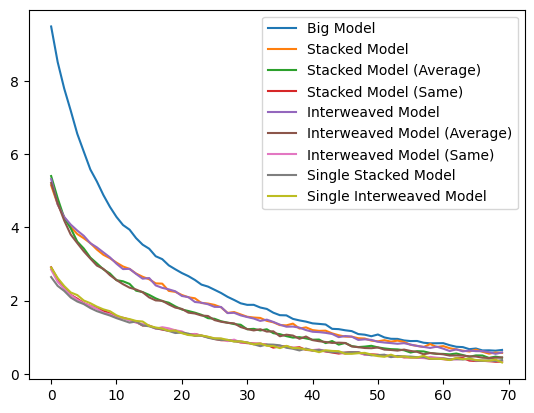

In [159]:
df3.plot()

In [160]:
df3.to_pickle('Wiki2_Triple_model_curves')

In [75]:
sample = None
for i in train_dataloader:
    sample = i['input_ids']
    break

In [78]:

# Used to calculate the number of FLOPs in a model 
# calculate_flops(model=Model(16).to(device), kwargs={'inp':sample})



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  15.29 M 
fwd MACs:                                                               288.11 GMACs
fwd FLOPs:                                                              576.88 GFLOPS
fwd+bwd MACs:                                                           864.32 GMACs
fwd+bwd FLOPs:                                                          1.73 TFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module c

('576.88 GFLOPS', '288.11 GMACs', '15.29 M')

### Four Models

In [163]:
# Calculate the split points
train_split_1_4 = len(train_dataset) // 4
train_split_2_4 = 2 * len(train_dataset) // 4
train_split_3_4 = 3 * len(train_dataset) // 4

val_split_1_4 = len(val_dataset) // 4
val_split_2_4 = 2 * len(val_dataset) // 4
val_split_3_4 = 3 * len(val_dataset) // 4

# Create subsets for each quarter
train_dataset_1_4 = Subset(train_dataset, range(train_split_1_4))
train_dataset_2_4 = Subset(train_dataset, range(train_split_1_4, train_split_2_4))
train_dataset_3_4 = Subset(train_dataset, range(train_split_2_4, train_split_3_4))
train_dataset_4_4 = Subset(train_dataset, range(train_split_3_4, len(train_dataset)))

val_dataset_1_4 = Subset(val_dataset, range(val_split_1_4))
val_dataset_2_4 = Subset(val_dataset, range(val_split_1_4, val_split_2_4))
val_dataset_3_4 = Subset(val_dataset, range(val_split_2_4, val_split_3_4))
val_dataset_4_4 = Subset(val_dataset, range(val_split_3_4, len(val_dataset)))

# Create DataLoaders for each quarter
train_dataloader_1_4 = DataLoader(train_dataset_1_4, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_2_4 = DataLoader(train_dataset_2_4, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_3_4 = DataLoader(train_dataset_3_4, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_4_4 = DataLoader(train_dataset_4_4, shuffle=True, batch_size=batch_size, collate_fn=data_collator)

val_dataloader_1_4 = DataLoader(val_dataset_1_4, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_2_4 = DataLoader(val_dataset_2_4, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_3_4 = DataLoader(val_dataset_3_4, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_4_4 = DataLoader(val_dataset_4_4, shuffle=False, batch_size=batch_size, collate_fn=data_collator)

# Convert to lists if necessary
train_dataloader_1_4 = list(train_dataloader_1_4)
train_dataloader_2_4 = list(train_dataloader_2_4)
train_dataloader_3_4 = list(train_dataloader_3_4)
train_dataloader_4_4 = list(train_dataloader_4_4)

val_dataloader_1_4 = list(val_dataloader_1_4)
val_dataloader_2_4 = list(val_dataloader_2_4)
val_dataloader_3_4 = list(val_dataloader_3_4)
val_dataloader_4_4 = list(val_dataloader_4_4)

In [164]:
model4_1 = Model(4).to(device)
optimizer4_1 = torch.optim.Adam(model4_1.parameters(), lr=learning_rate)

model4_2 = Model(4).to(device)
optimizer4_2 = torch.optim.Adam(model4_2.parameters(), lr=learning_rate)

model4_3 = Model(4).to(device)
optimizer4_3 = torch.optim.Adam(model4_3.parameters(), lr=learning_rate)

model4_4 = Model(4).to(device)
optimizer4_4 = torch.optim.Adam(model4_4.parameters(), lr=learning_rate)

In [165]:
train(model4_1, optimizer4_1, 30, train_dataloader_1_4, val_dataloader_1_4)
train(model4_2, optimizer4_2, 30, train_dataloader_2_4, val_dataloader_2_4)
train(model4_3, optimizer4_3, 30, train_dataloader_3_4, val_dataloader_3_4)
train(model4_4, optimizer4_4, 30, train_dataloader_4_4, val_dataloader_4_4)

Epoch 1, Train Loss: 10.5908, Val Loss: 9.9350
Epoch 2, Train Loss: 9.8026, Val Loss: 9.1507
Epoch 3, Train Loss: 9.1330, Val Loss: 8.3853
Epoch 4, Train Loss: 8.4546, Val Loss: 7.7329
Epoch 5, Train Loss: 7.8519, Val Loss: 7.0795
Epoch 6, Train Loss: 7.3061, Val Loss: 6.5023
Epoch 7, Train Loss: 6.8216, Val Loss: 6.0250
Epoch 8, Train Loss: 6.3428, Val Loss: 5.6322
Epoch 9, Train Loss: 5.9643, Val Loss: 5.2235
Epoch 10, Train Loss: 5.5819, Val Loss: 4.8601
Epoch 11, Train Loss: 5.2639, Val Loss: 4.5819
Epoch 12, Train Loss: 4.9883, Val Loss: 4.2987
Epoch 13, Train Loss: 4.7430, Val Loss: 4.0892
Epoch 14, Train Loss: 4.5220, Val Loss: 3.8903
Epoch 15, Train Loss: 4.3297, Val Loss: 3.7130
Epoch 16, Train Loss: 4.1284, Val Loss: 3.5524
Epoch 17, Train Loss: 3.9715, Val Loss: 3.3776
Epoch 18, Train Loss: 3.7925, Val Loss: 3.2168
Epoch 19, Train Loss: 3.6224, Val Loss: 3.1344
Epoch 20, Train Loss: 3.5283, Val Loss: 3.0080
Epoch 21, Train Loss: 3.3781, Val Loss: 2.9163
Epoch 22, Train Loss:

[9.924049377441406,
 9.18587131500244,
 8.443549919128419,
 7.778538799285888,
 7.187076473236084,
 6.532893085479737,
 6.064302921295166,
 5.587611484527588,
 5.300025558471679,
 4.923692512512207,
 4.5954833984375,
 4.370462894439697,
 4.142061805725097,
 3.915741300582886,
 3.787037801742554,
 3.578040599822998,
 3.4303598403930664,
 3.2942681312561035,
 3.1716026782989504,
 3.063149166107178,
 2.9374897956848143,
 2.8211555957794188,
 2.717837333679199,
 2.631736326217651,
 2.540820598602295,
 2.445720100402832,
 2.3583571910858154,
 2.2711021900177,
 2.1897669792175294,
 2.1185183048248293]

In [166]:
Four_Stacked_Model = StackedModel([model4_1, model4_2, model4_3, model4_4], num_models = 4)
optimizer_four_stacked = torch.optim.Adam(Four_Stacked_Model.parameters(), lr=learning_rate)

In [167]:
four_stack_curve = train(Four_Stacked_Model, optimizer_four_stacked, 70, train_dataloader, val_dataloader)
torch.save(Four_Stacked_Model.state_dict(), 'models/Four_Stacked_Model.pth')

Epoch 1, Train Loss: 7.1100, Val Loss: 5.0735
Epoch 2, Train Loss: 5.6716, Val Loss: 4.5574
Epoch 3, Train Loss: 5.2651, Val Loss: 4.3211
Epoch 4, Train Loss: 4.9897, Val Loss: 3.9756
Epoch 5, Train Loss: 4.7751, Val Loss: 3.8593
Epoch 6, Train Loss: 4.5752, Val Loss: 3.7093
Epoch 7, Train Loss: 4.4626, Val Loss: 3.4900
Epoch 8, Train Loss: 4.3196, Val Loss: 3.4496
Epoch 9, Train Loss: 4.1883, Val Loss: 3.3128
Epoch 10, Train Loss: 4.0466, Val Loss: 3.1545
Epoch 11, Train Loss: 3.9678, Val Loss: 3.0342
Epoch 12, Train Loss: 3.8263, Val Loss: 3.0375
Epoch 13, Train Loss: 3.7317, Val Loss: 2.8469
Epoch 14, Train Loss: 3.6442, Val Loss: 2.7772
Epoch 15, Train Loss: 3.5362, Val Loss: 2.6870
Epoch 16, Train Loss: 3.4487, Val Loss: 2.5718
Epoch 17, Train Loss: 3.3569, Val Loss: 2.5326
Epoch 18, Train Loss: 3.2490, Val Loss: 2.3826
Epoch 19, Train Loss: 3.1869, Val Loss: 2.3580
Epoch 20, Train Loss: 3.0777, Val Loss: 2.3120
Epoch 21, Train Loss: 3.0273, Val Loss: 2.2135
Epoch 22, Train Loss: 

In [168]:
Four_Stacked_Avg = StackedModelAVG([model4_1, model4_2, model4_3, model4_4], num_models = 4)
optimizer_four_stacked_avg = torch.optim.Adam(Four_Stacked_Avg.parameters(), lr=learning_rate)

In [169]:
four_stack_avg_curve = train(Four_Stacked_Avg, optimizer_four_stacked_avg, 70, train_dataloader, val_dataloader)
torch.save(Four_Stacked_Avg.state_dict(), 'models/Four_Stacked_Avg.pth')

Epoch 1, Train Loss: 7.6048, Val Loss: 6.3323
Epoch 2, Train Loss: 6.6631, Val Loss: 5.6834
Epoch 3, Train Loss: 6.1597, Val Loss: 5.1503
Epoch 4, Train Loss: 5.7733, Val Loss: 4.7387
Epoch 5, Train Loss: 5.4063, Val Loss: 4.4228
Epoch 6, Train Loss: 5.0934, Val Loss: 4.0743
Epoch 7, Train Loss: 4.8245, Val Loss: 3.8500
Epoch 8, Train Loss: 4.5716, Val Loss: 3.6018
Epoch 9, Train Loss: 4.3510, Val Loss: 3.3827
Epoch 10, Train Loss: 4.1556, Val Loss: 3.2169
Epoch 11, Train Loss: 4.0106, Val Loss: 3.1304
Epoch 12, Train Loss: 3.8437, Val Loss: 2.9357
Epoch 13, Train Loss: 3.6938, Val Loss: 2.7520
Epoch 14, Train Loss: 3.5787, Val Loss: 2.6711
Epoch 15, Train Loss: 3.4485, Val Loss: 2.5698
Epoch 16, Train Loss: 3.3346, Val Loss: 2.4463
Epoch 17, Train Loss: 3.2361, Val Loss: 2.3811
Epoch 18, Train Loss: 3.1316, Val Loss: 2.2859
Epoch 19, Train Loss: 3.0291, Val Loss: 2.2059
Epoch 20, Train Loss: 2.9244, Val Loss: 2.0887
Epoch 21, Train Loss: 2.8421, Val Loss: 2.1021
Epoch 22, Train Loss: 

In [170]:
Four_Stacked_Same = StackedModel([model4_1, model4_2, model4_3, model4_4], num_models = 4, same=True)
optimizer_four_stacked_same = torch.optim.Adam(Four_Stacked_Same.parameters(), lr=learning_rate)

In [171]:
four_stack_same_curve = train(Four_Stacked_Same, optimizer_four_stacked_same, 70, train_dataloader, val_dataloader)
torch.save(Four_Stacked_Same.state_dict(), 'models/Four_Stacked_Same.pth')

Epoch 1, Train Loss: 5.5611, Val Loss: 3.5305
Epoch 2, Train Loss: 4.1847, Val Loss: 2.9212
Epoch 3, Train Loss: 3.7272, Val Loss: 2.6730
Epoch 4, Train Loss: 3.4409, Val Loss: 2.4370
Epoch 5, Train Loss: 3.2165, Val Loss: 2.2999
Epoch 6, Train Loss: 3.0689, Val Loss: 2.1780
Epoch 7, Train Loss: 2.9234, Val Loss: 2.0302
Epoch 8, Train Loss: 2.7589, Val Loss: 1.9439
Epoch 9, Train Loss: 2.6594, Val Loss: 1.8833
Epoch 10, Train Loss: 2.5570, Val Loss: 1.7356
Epoch 11, Train Loss: 2.4267, Val Loss: 1.6764
Epoch 12, Train Loss: 2.3599, Val Loss: 1.6613
Epoch 13, Train Loss: 2.2738, Val Loss: 1.5747
Epoch 14, Train Loss: 2.1786, Val Loss: 1.5656
Epoch 15, Train Loss: 2.1160, Val Loss: 1.4824
Epoch 16, Train Loss: 2.0396, Val Loss: 1.3941
Epoch 17, Train Loss: 1.9518, Val Loss: 1.3526
Epoch 18, Train Loss: 1.8861, Val Loss: 1.3619
Epoch 19, Train Loss: 1.8584, Val Loss: 1.3098
Epoch 20, Train Loss: 1.7803, Val Loss: 1.2406
Epoch 21, Train Loss: 1.7412, Val Loss: 1.2302
Epoch 22, Train Loss: 

In [172]:
Four_InterWeaved_Model = InterWeavedModel([model4_1, model4_2, model4_3, model4_4], num_models = 4)
optimizer_four_interweaved = torch.optim.Adam(Four_InterWeaved_Model.parameters(), lr=learning_rate)

In [173]:
four_interweaved_curve = train(Four_InterWeaved_Model, optimizer_four_interweaved, 70, train_dataloader, val_dataloader)
torch.save(Four_InterWeaved_Model.state_dict(), 'models/Four_InterWeaved_Model.pth')

Epoch 1, Train Loss: 7.2770, Val Loss: 5.5200
Epoch 2, Train Loss: 5.9534, Val Loss: 4.6584
Epoch 3, Train Loss: 5.4043, Val Loss: 4.3470
Epoch 4, Train Loss: 5.1145, Val Loss: 4.1658
Epoch 5, Train Loss: 4.8798, Val Loss: 3.8655
Epoch 6, Train Loss: 4.6877, Val Loss: 3.8207
Epoch 7, Train Loss: 4.5108, Val Loss: 3.6057
Epoch 8, Train Loss: 4.3751, Val Loss: 3.3989
Epoch 9, Train Loss: 4.2503, Val Loss: 3.3314
Epoch 10, Train Loss: 4.0674, Val Loss: 3.2365
Epoch 11, Train Loss: 3.9769, Val Loss: 3.0948
Epoch 12, Train Loss: 3.8511, Val Loss: 3.0300
Epoch 13, Train Loss: 3.7592, Val Loss: 2.8484
Epoch 14, Train Loss: 3.6348, Val Loss: 2.6989
Epoch 15, Train Loss: 3.5454, Val Loss: 2.6657
Epoch 16, Train Loss: 3.4470, Val Loss: 2.5089
Epoch 17, Train Loss: 3.3378, Val Loss: 2.5558
Epoch 18, Train Loss: 3.2810, Val Loss: 2.4450
Epoch 19, Train Loss: 3.1436, Val Loss: 2.3329
Epoch 20, Train Loss: 3.0956, Val Loss: 2.2713
Epoch 21, Train Loss: 3.0064, Val Loss: 2.2319
Epoch 22, Train Loss: 

In [174]:
Four_InterWeaved_Model_avg = InterWeavedModelAVG([model4_1, model4_2, model4_3, model4_4], num_models = 4)
optimizer_four_interweaved_avg = torch.optim.Adam(Four_InterWeaved_Model_avg.parameters(), lr=learning_rate)

In [175]:
four_interweaved_avg_curve = train(Four_InterWeaved_Model_avg, optimizer_four_interweaved_avg, 70, train_dataloader, val_dataloader)
torch.save(Four_InterWeaved_Model_avg.state_dict(), 'models/Four_InterWeaved_Model_avg.pth')

Epoch 1, Train Loss: 7.3314, Val Loss: 6.1827
Epoch 2, Train Loss: 6.5291, Val Loss: 5.5129
Epoch 3, Train Loss: 6.0614, Val Loss: 5.0762
Epoch 4, Train Loss: 5.6430, Val Loss: 4.6297
Epoch 5, Train Loss: 5.2901, Val Loss: 4.3406
Epoch 6, Train Loss: 4.9996, Val Loss: 3.9724
Epoch 7, Train Loss: 4.7218, Val Loss: 3.7491
Epoch 8, Train Loss: 4.4839, Val Loss: 3.5160
Epoch 9, Train Loss: 4.3038, Val Loss: 3.3626
Epoch 10, Train Loss: 4.0948, Val Loss: 3.2043
Epoch 11, Train Loss: 3.9468, Val Loss: 3.0289
Epoch 12, Train Loss: 3.7739, Val Loss: 2.8879
Epoch 13, Train Loss: 3.6470, Val Loss: 2.7556
Epoch 14, Train Loss: 3.5349, Val Loss: 2.6317
Epoch 15, Train Loss: 3.4093, Val Loss: 2.5389
Epoch 16, Train Loss: 3.2676, Val Loss: 2.4248
Epoch 17, Train Loss: 3.1642, Val Loss: 2.2757
Epoch 18, Train Loss: 3.0466, Val Loss: 2.2754
Epoch 19, Train Loss: 2.9730, Val Loss: 2.1775
Epoch 20, Train Loss: 2.8864, Val Loss: 2.1038
Epoch 21, Train Loss: 2.7517, Val Loss: 2.0650
Epoch 22, Train Loss: 

In [176]:
Four_InterWeaved_Model_same = InterWeavedModel([model4_1, model4_2, model4_3, model4_4], num_models = 4, same=True)
optimizer_four_interweaved_same = torch.optim.Adam(Four_InterWeaved_Model_same.parameters(), lr=learning_rate)

In [177]:
four_interweaved_same_curve = train(Four_InterWeaved_Model_same, optimizer_four_interweaved_same, 70, train_dataloader, val_dataloader)
torch.save(Four_InterWeaved_Model_same.state_dict(), 'models/Four_InterWeaved_Model_same.pth')

Epoch 1, Train Loss: 4.9986, Val Loss: 3.2209
Epoch 2, Train Loss: 4.0076, Val Loss: 2.8484
Epoch 3, Train Loss: 3.6213, Val Loss: 2.5998
Epoch 4, Train Loss: 3.3534, Val Loss: 2.3601
Epoch 5, Train Loss: 3.1416, Val Loss: 2.2324
Epoch 6, Train Loss: 2.9945, Val Loss: 2.1054
Epoch 7, Train Loss: 2.8266, Val Loss: 2.0236
Epoch 8, Train Loss: 2.6919, Val Loss: 1.9268
Epoch 9, Train Loss: 2.6016, Val Loss: 1.8170
Epoch 10, Train Loss: 2.5083, Val Loss: 1.7413
Epoch 11, Train Loss: 2.4047, Val Loss: 1.6715
Epoch 12, Train Loss: 2.3146, Val Loss: 1.6429
Epoch 13, Train Loss: 2.2167, Val Loss: 1.6203
Epoch 14, Train Loss: 2.1367, Val Loss: 1.4960
Epoch 15, Train Loss: 2.0919, Val Loss: 1.4695
Epoch 16, Train Loss: 2.0034, Val Loss: 1.4287
Epoch 17, Train Loss: 1.9371, Val Loss: 1.3473
Epoch 18, Train Loss: 1.8983, Val Loss: 1.3161
Epoch 19, Train Loss: 1.8208, Val Loss: 1.2842
Epoch 20, Train Loss: 1.7941, Val Loss: 1.2391
Epoch 21, Train Loss: 1.7217, Val Loss: 1.2155
Epoch 22, Train Loss: 

In [178]:
Four_single_stack = StackedModel([model4_1, model4_1, model4_1, model4_1], num_models = 4)
optimizer_four_single_stack = torch.optim.Adam(Four_single_stack.parameters(), lr=learning_rate)

In [179]:
four_single_stack_curve = train(Four_single_stack, optimizer_four_single_stack, 70, train_dataloader, val_dataloader)
torch.save(Four_single_stack.state_dict(), 'models/Four_single_stack.pth')

Epoch 1, Train Loss: 5.1752, Val Loss: 3.3279
Epoch 2, Train Loss: 3.8908, Val Loss: 2.9059
Epoch 3, Train Loss: 3.5137, Val Loss: 2.5781
Epoch 4, Train Loss: 3.2685, Val Loss: 2.4512
Epoch 5, Train Loss: 3.1116, Val Loss: 2.3297
Epoch 6, Train Loss: 2.9380, Val Loss: 2.1589
Epoch 7, Train Loss: 2.7678, Val Loss: 2.0606
Epoch 8, Train Loss: 2.6162, Val Loss: 1.8769
Epoch 9, Train Loss: 2.5196, Val Loss: 1.7503
Epoch 10, Train Loss: 2.3918, Val Loss: 1.7126
Epoch 11, Train Loss: 2.3254, Val Loss: 1.6841
Epoch 12, Train Loss: 2.2186, Val Loss: 1.6001
Epoch 13, Train Loss: 2.1504, Val Loss: 1.5420
Epoch 14, Train Loss: 2.0786, Val Loss: 1.4725
Epoch 15, Train Loss: 2.0279, Val Loss: 1.3658
Epoch 16, Train Loss: 1.9709, Val Loss: 1.3742
Epoch 17, Train Loss: 1.8774, Val Loss: 1.3043
Epoch 18, Train Loss: 1.8334, Val Loss: 1.2458
Epoch 19, Train Loss: 1.7844, Val Loss: 1.2655
Epoch 20, Train Loss: 1.7281, Val Loss: 1.2591
Epoch 21, Train Loss: 1.6932, Val Loss: 1.1357
Epoch 22, Train Loss: 

In [180]:
Four_single_interweaved = InterWeavedModel([model4_1, model4_1, model4_1, model4_1], num_models = 4)
optimizer_four_single_interweaved = torch.optim.Adam(Four_single_interweaved.parameters(), lr=learning_rate)

In [181]:
four_single_interweaved_curve = train(Four_single_interweaved, optimizer_four_single_interweaved, 70, train_dataloader, val_dataloader)


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.14 GiB. GPU 

In [ ]:
Scratch_Four_Big_Model = Model(16).to(device)
optimizer_scratch_four_big = torch.optim.Adam(Scratch_Four_Big_Model.parameters(), lr=learning_rate)

In [ ]:
scratch_four_big_curve = train(Scratch_Four_Big_Model, optimizer_scratch_four_big, 70, train_dataloader, val_dataloader)
torch.save(Scratch_Four_Big_Model.state_dict(), 'models/Scratch_Four_Big_Model.pth')

In [ ]:
df4 = pd.DataFrame({'Big Model': scratch_four_big_curve, 'Stacked Model': four_stack_curve, 'Stacked Model (Average)': four_stack_avg_curve, 'Stacked Model (Same)': four_stack_same_curve, 'Interweaved Model': four_interweaved_curve, 'Interweaved Model (Average)': four_interweaved_avg_curve, 'Interweaved Model (Same)': four_interweaved_same_curve, 'Single Stacked Model': four_single_stack_curve, 'Single Interweaved Model': four_single_interweaved_curve})

In [ ]:
df4.plot()

In [ ]:
df4.to_pickle('Wiki2_Four_model_curves')